# **0. 사용 모듈**
---

In [1]:
# Data Handling
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Data Visualizing
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from tqdm import tqdm

#model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
import joblib

# etc.
import warnings
warnings.filterwarnings('ignore')

# colab 환경설정
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1. 데이터 불러오기**
---

In [2]:
path = "/content/drive/MyDrive/BusProject/NumofPassenger/CSV/"
df_list = []

for i in tqdm( range(1,120) ):
    df_list.append( pd.read_csv(path+str(i)+".csv", encoding='cp949') )
    
df = pd.concat( df_list ).reset_index()

100%|██████████| 119/119 [00:44<00:00,  2.65it/s]


In [30]:
df[ (df.시간 == 18) | (df.시간 == 19) ]

,일자,노선명,정류장명,ARS_ID,시간,승하차,거래건수,weekday
12,2022-03-14,1187,광주시립미술관하정웅미술관,2049.0,18,승차,2,0
24,2022-03-14,1187,광주역,4334.0,18,하차,1,0
28,2022-03-14,1187,광주역(동),4529.0,18,승차,1,0
39,2022-03-14,1187,광주종합버스터미널,2001.0,18,승차,1,0
40,2022-03-14,1187,광주종합버스터미널,2001.0,18,환승,2,0
...,...,...,...,...,...,...,...,...
5995205,2022-04-30,충효187,장원초교(동),1034.0,18,하차,4,5
5995219,2022-04-30,충효187,장원초교(서),1036.0,18,승차,2,5
5995220,2022-04-30,충효187,장원초교(서),1036.0,18,하차,1,5
5995234,2022-04-30,충효187,충장사(북),4324.0,19,승차,1,5


In [ ]:
df.head()

,index,일자,노선명,정류장명,ARS_ID,시간,승하차,거래건수
0,0,20220301,1187,4수원지,4263.0,10,승차,1
1,1,20220301,1187,4수원지,4264.0,12,승차,1
2,2,20220301,1187,4수원지,4264.0,13,하차,1
3,3,20220301,1187,4수원지위,4268.0,11,하차,1
4,4,20220301,1187,4수원지위,4268.0,13,하차,2


In [3]:
df = df.drop(['index'], axis=1)
df['일자'] = pd.to_datetime(df.일자, format='%Y%m%d')

In [ ]:
df.head()

,일자,노선명,정류장명,ARS_ID,시간,승하차,거래건수
0,2022-03-01,1187,4수원지,4263.0,10,승차,1
1,2022-03-01,1187,4수원지,4264.0,12,승차,1
2,2022-03-01,1187,4수원지,4264.0,13,하차,1
3,2022-03-01,1187,4수원지위,4268.0,11,하차,1
4,2022-03-01,1187,4수원지위,4268.0,13,하차,2


In [ ]:
print( "총 관측치의 수: {:,}".format(len(df)) )

총 관측치의 수: 7,460,871


# **2. EDA**
---

### 1) Target 데이터 분포 확인

1      3528060
2      1510095
3       791426
4       468578
5       301207
        ...   
146          1
125          1
144          1
172          1
145          1
Name: 거래건수, Length: 162, dtype: int64


array([3528060, 1510095,  791426,  468578,  301207,  204271,  144338,
        105046,   77994,   59695,   46714,   36881,   28739,   23731,
         19562,   15905,   13086,   11076,    9237,    7923,    6691,
          5837,    5078,    4365,    3683,    3319,    2958,    2537,
          2286,    1957,    1849,    1648,    1409,    1278,    1075,
           988,     891,     837,     710,     648,     553,     547,
           491,     419,     384,     373,     348,     301,     274,
           241,     221,     200,     185,     169,     161,     145,
           130,     123,     101,      94,      93,      89,      88,
            78,      71,      64,      58,      54,      47,      44,
            41,      40,      39,      35,      29,      27,      26,
            25,      22,      20,      18,      17,      16,      14,
            13,      12,      11,      10,       9,       8,       7,
             6,       5,       4,       3,       2,       1])

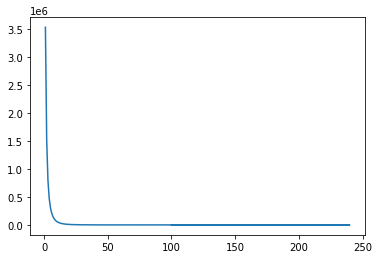

In [ ]:
print(df.거래건수.value_counts())
plt.plot(df.거래건수.value_counts())

df.거래건수.value_counts().unique()

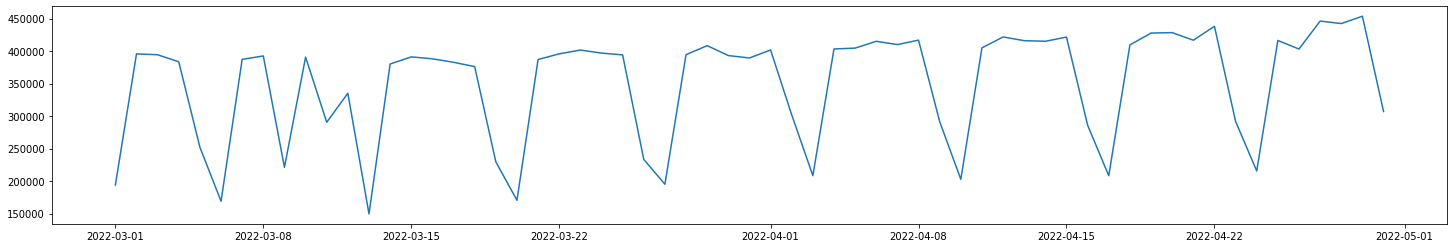

In [ ]:
fig = plt.figure(figsize=(25,4))
fig.add_subplot()
plt.plot(df.groupby('일자')['거래건수'].sum())

<br>
3월 첫 째, 둘 째주는 개강 및 개학, 정정기간 등 여러 행사가 많아 패턴 불규칙<br>
따라서 3월 셋 째주(3월 14일) 데이터부터 사용<br>
<br>

In [4]:
df = df[df.일자>'2022-03-13'].reset_index()
df = df.drop(['index'], axis=1)
df.head()

,일자,노선명,정류장명,ARS_ID,시간,승하차,거래건수
0,2022-03-14,1187,4수원지,4263.0,8,승차,2
1,2022-03-14,1187,4수원지,4263.0,12,승차,1
2,2022-03-14,1187,4수원지,4263.0,13,승차,1
3,2022-03-14,1187,4수원지,4263.0,13,하차,2
4,2022-03-14,1187,4수원지,4263.0,17,승차,2


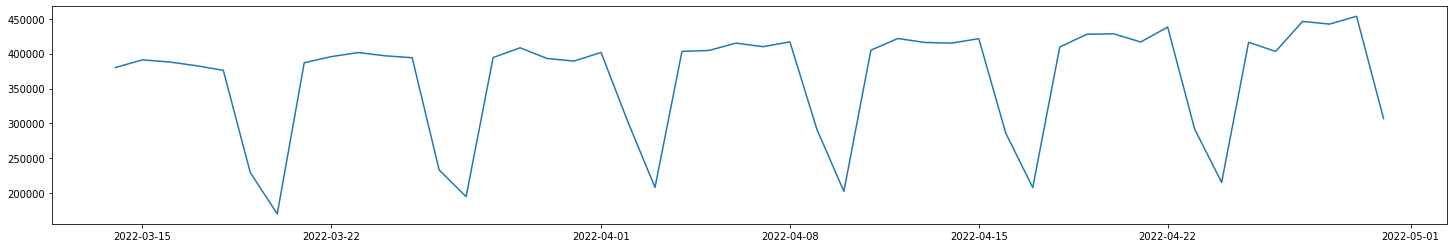

In [ ]:
fig = plt.figure(figsize=(25,4))
fig.add_subplot()
plt.plot(df.groupby('일자')['거래건수'].sum())

<br>
일주일을 기점으로 패턴이 잘 나타나고 있는 모습이다.<br>
<br>

### 2) 정류장명과 ARS_ID의 1:1 대응여부 확인

In [ ]:
print(len(df.정류장명.unique()), len(df.ARS_ID.unique()), sep='\n')
len(df.정류장명.unique()) == len(df.ARS_ID.unique())

1496
2803


False

In [ ]:
nunique_df = df.groupby('정류장명')['ARS_ID'].nunique()

print( nunique_df.unique(), end='\n\n\n' )
print( nunique_df, end='\n\n\n' )
print( nunique_df.value_counts(), end='\n\n\n' )

[2 1 4 3]


정류장명
31사단          2
4.19기념관       2
4수원지          2
4수원지위         2
5.18기념공원      2
             ..
흑석사거리(동)      2
흑석사거리(서)      2
희망가아파트        2
힐스테이트 각화      2
힐스테이트연제아파트    2
Name: ARS_ID, Length: 1495, dtype: int64


2    1293
1     196
3       4
4       2
Name: ARS_ID, dtype: int64




<br>
대부분의 정류장은 정류장명마다 2개의 ARS_ID를 가지고 있다<br>
-> 하나의 정류장마다 가는 방향, 오는 방향이 있기 때문에 총 2개의 ARS_ID를 가지고 있는 것<br>
3개 이상인 정류장도 있길래 확인해보았다.<br>
<br>

In [ ]:
nunique_df[nunique_df>=3]

정류장명
동산마을        4
명도삼거리       3
문화전당역       3
살레시오고입구     4
평촌          3
효령노인복지타운    3
Name: ARS_ID, dtype: int64

In [ ]:
df[df.정류장명=='동산마을'].ARS_ID.unique()

array([5985., 5965., 6021., 6022.])

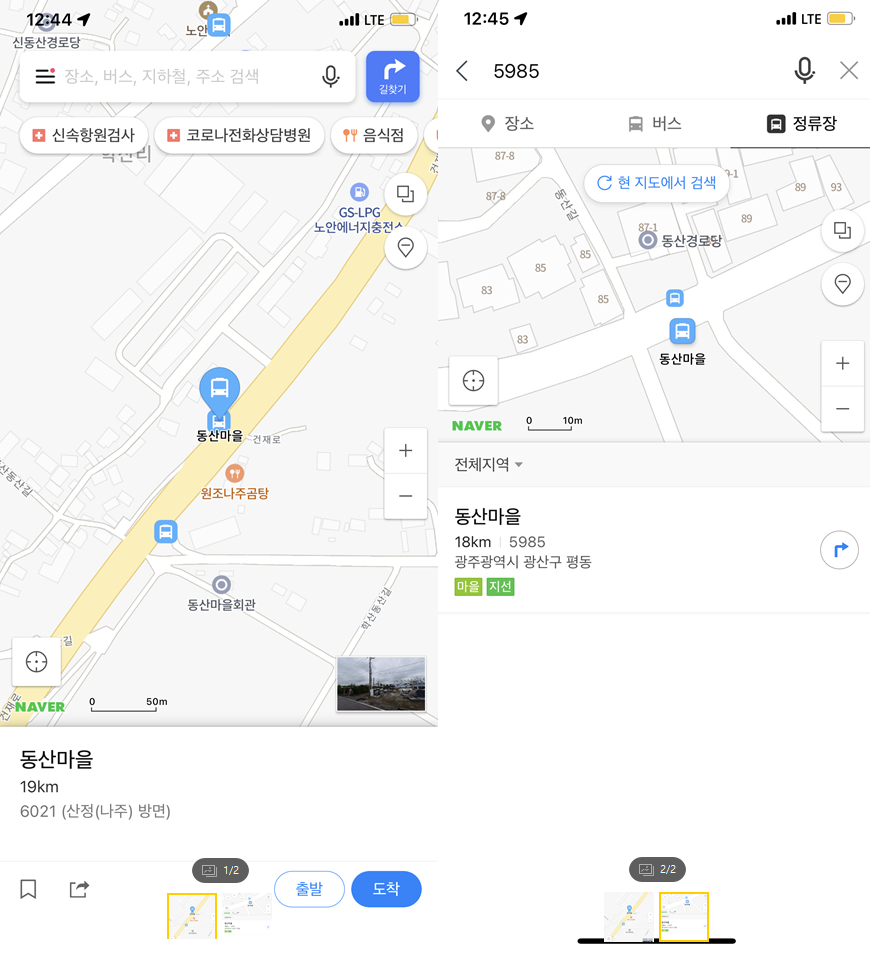

<br>
* 동일 이름의 정류장이 있었던 것으로 확인<br>
* 따라서 정류장의 고유값으로는 정류장명이 아닌 ARS_ID를 사용하는 것이 바람직 함.<br>
<br>

### 3) 결측치 확인

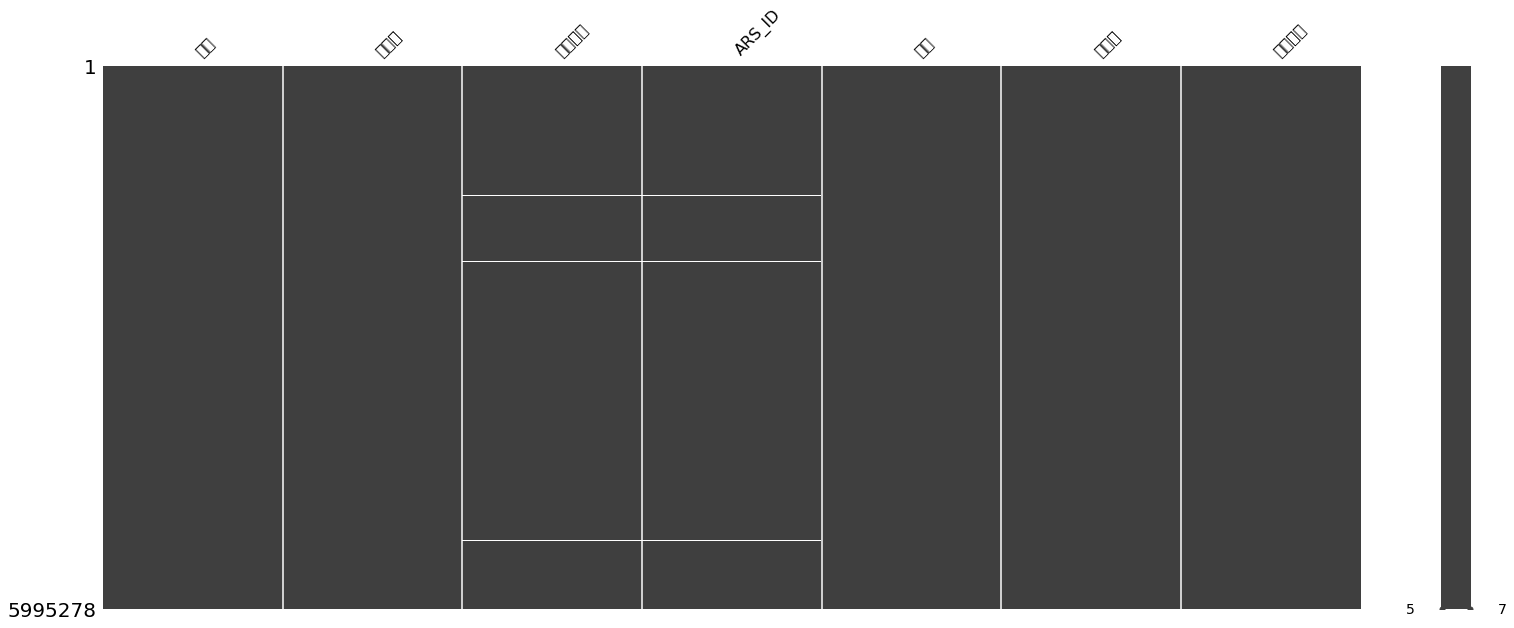

In [ ]:
msno.matrix(df)

In [ ]:
df.isnull().sum()

일자            0
노선명           0
정류장명      39426
ARS_ID    39711
시간            0
승하차           0
거래건수          0
dtype: int64

In [ ]:
df[df.ARS_ID.isnull()]

,일자,노선명,정류장명,ARS_ID,시간,승하차,거래건수
709,2022-03-14,1187,NaN,NaN,7,승차,1
710,2022-03-14,1187,NaN,NaN,8,승차,8
711,2022-03-14,1187,NaN,NaN,9,승차,6
712,2022-03-14,1187,NaN,NaN,10,승차,1
713,2022-03-14,1187,NaN,NaN,11,승차,2
...,...,...,...,...,...,...,...
5995269,2022-04-30,충효187,NaN,NaN,8,승차,3
5995270,2022-04-30,충효187,NaN,NaN,9,승차,1
5995271,2022-04-30,충효187,NaN,NaN,14,승차,1
5995272,2022-04-30,충효187,NaN,NaN,16,승차,2


In [ ]:
df[df.정류장명.isnull()]

,일자,노선명,정류장명,ARS_ID,시간,승하차,거래건수
709,2022-03-14,1187,NaN,NaN,7,승차,1
710,2022-03-14,1187,NaN,NaN,8,승차,8
711,2022-03-14,1187,NaN,NaN,9,승차,6
712,2022-03-14,1187,NaN,NaN,10,승차,1
713,2022-03-14,1187,NaN,NaN,11,승차,2
...,...,...,...,...,...,...,...
5995269,2022-04-30,충효187,NaN,NaN,8,승차,3
5995270,2022-04-30,충효187,NaN,NaN,9,승차,1
5995271,2022-04-30,충효187,NaN,NaN,14,승차,1
5995272,2022-04-30,충효187,NaN,NaN,16,승차,2


<br>
정류장명과 ARS_ID간의 null값 개수가 다르고, 정류장명과 정류장 ID가 Null값인 관측치가 상당수 존재.<br>
전체 데이터 셋에 비해서 매우 적은 양(약 0.5%), 또한 정류장명과 ARS_ID는 회귀식에 데이터가 아님<br>
따라서 정류장명과 ARS_ID간의 대응관계만 맞춰주고, 나머지 Null값은 모두 Drop<br>
<br>

In [ ]:
df[df.정류장명.notnull() & df.ARS_ID.isnull()]

,일자,노선명,정류장명,ARS_ID,시간,승하차,거래건수
23430,2022-03-14,마을788,시화문화마을문화관,NaN,7,승차,5
23431,2022-03-14,마을788,시화문화마을문화관,NaN,8,승차,1
23432,2022-03-14,마을788,시화문화마을문화관,NaN,9,승차,1
23433,2022-03-14,마을788,시화문화마을문화관,NaN,10,환승,1
23434,2022-03-14,마을788,시화문화마을문화관,NaN,11,승차,1
...,...,...,...,...,...,...,...
5900734,2022-04-30,마을788,시화문화마을문화관,NaN,7,승차,4
5900735,2022-04-30,마을788,시화문화마을문화관,NaN,9,승차,1
5900736,2022-04-30,마을788,시화문화마을문화관,NaN,14,승차,1
5900737,2022-04-30,마을788,시화문화마을문화관,NaN,15,승차,2


In [ ]:
df[df.정류장명.isnull() & df.ARS_ID.notnull()]

,일자,노선명,정류장명,ARS_ID,시간,승하차,거래건수


<br>

In [ ]:
df[df.정류장명.notnull() & df.ARS_ID.isnull()].정류장명.unique()

array(['시화문화마을문화관'], dtype=object)

<br>
정류장명은 존재하지만 ARS_ID가 존재하지 않는 경우 존재<br>
확인 결과, 각화중 방향 사회문화마을문화관 정류장은 따로 ARS_ID가 존재하지 않았음<br>
<br>

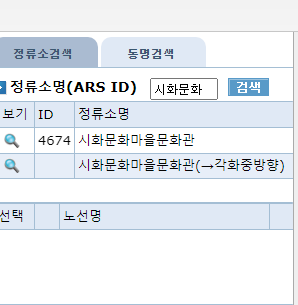

# **3. 데이터 전처리**
---

### 0) 광주광역시 노선 정보 데이터 불러오기

In [ ]:
# url = 'D:/python_projects/BusStopCongestionProject/Data/Original_data/GwangjuBusInfo/Excel/광주광역시_시내버스노선정보_11_30_2020.xls'
# BusInfo = pd.read_excel(url, sheet_name=None)

In [ ]:
# bus_dict = {}
# for i in enumerate(BusInfo):
#     key = i[1]
#     item = BusInfo[ key ].filter(regex='출발')
#     if (len(item.columns)>1):
#         item = list( set(item.iloc[:,0]) | set(item.iloc[:,1]) )
    
#     bus_dict[key] = item

In [ ]:
# for bus_names in df[df.ARS_ID.isnull()].노선명.unique():
#     if(bus_names in bus_dict.keys()):
#         print("[%s]\n총 정류장 수: %d\n데이터셋의 정류장 수: %d\n\n"
#               %(bus_names,len(bus_dict[bus_names]), df[df.노선명==bus_names].정류장명.nunique()))

[1187]
총 정류장 수: 56
데이터셋의 정류장 수: 54


[1187-1]
총 정류장 수: 23
데이터셋의 정류장 수: 21


[419]
총 정류장 수: 49
데이터셋의 정류장 수: 48


[518]
총 정류장 수: 71
데이터셋의 정류장 수: 70


[금남57]
총 정류장 수: 57
데이터셋의 정류장 수: 55


[금남58]
총 정류장 수: 30
데이터셋의 정류장 수: 28


[금남59]
총 정류장 수: 57
데이터셋의 정류장 수: 55


[금호36]
총 정류장 수: 65
데이터셋의 정류장 수: 63


[금호46]
총 정류장 수: 54
데이터셋의 정류장 수: 51


[대촌270]
총 정류장 수: 46
데이터셋의 정류장 수: 43


[대촌69]
총 정류장 수: 41
데이터셋의 정류장 수: 39


[대촌70]
총 정류장 수: 49
데이터셋의 정류장 수: 47


[대촌71]
총 정류장 수: 41
데이터셋의 정류장 수: 39


[매월06]
총 정류장 수: 34
데이터셋의 정류장 수: 32


[매월16]
총 정류장 수: 70
데이터셋의 정류장 수: 68


[매월26]
총 정류장 수: 52
데이터셋의 정류장 수: 50


[문흥18]
총 정류장 수: 65
데이터셋의 정류장 수: 64


[문흥39]
총 정류장 수: 60
데이터셋의 정류장 수: 60


[문흥53]
총 정류장 수: 25
데이터셋의 정류장 수: 23


[문흥80]
총 정류장 수: 39
데이터셋의 정류장 수: 36


[봉선27]
총 정류장 수: 71
데이터셋의 정류장 수: 69


[봉선37]
총 정류장 수: 81
데이터셋의 정류장 수: 79


[봉선76]
총 정류장 수: 50
데이터셋의 정류장 수: 49


[상무63]
총 정류장 수: 32
데이터셋의 정류장 수: 30


[상무64]
총 정류장 수: 43
데이터셋의 정류장 수: 40


[송암31]
총 정류장 수: 33
데이터셋의 정류장 수: 32


[송암47]
총 정류장 수: 65
데이터셋의 정류장 수: 65




In [ ]:
# for bus_names in df[df.ARS_ID.isnull()].노선명.unique():
#     if(bus_names in bus_dict.keys()):
#         whole_bus = set( bus_dict[bus_names] )
#         dataset_bus = set( df[df.노선명==bus_names].정류장명.unique() )
#         print("%s"%bus_names)
#         print( list(whole_bus - dataset_bus ), end='\n\n' )

1187
['국립아시아문화전당(구,도청)', '농성1동주민센터']

1187-1
['5.18민주화운동기록관', '국립아시아문화전당(구,도청)', '농성1동주민센터']

419
['국립아시아문화전당(구,도청)', '농성1동주민센터']

518
['보훈회관/518민주화운동교육관', '중소기업진흥공단 호남연수원', '국립아시아문화전당(구,도청)']

금남57
['국립아시아문화전당(구,도청)', '농성1동주민센터', '문화전당역(1130)']

금남58
['국립아시아문화전당(구,도청)', 'NC백화점', '농성1동주민센터']

금남59
['월드컵경기장정문', '국립아시아문화전당(구,도청)', '농성1동주민센터']

금호36
['국립아시아문화전당(구,도청)', '농성1동주민센터']

금호46
['대창운수', '농성1동주민센터']

대촌270
['매월동(북)', '농성1동주민센터', '서창농협벽진지점']

대촌69
['칠석', '서창농협벽진지점']

대촌70
['농성1동주민센터']

대촌71
['서남하이츠/광주국제양궁장', '농성1동주민센터']

매월06
['백운초교(남)', '농성1동주민센터']

매월16
['대창운수']

매월26
['농성1동주민센터', '광주광역시교육청/광덕고']

문흥18
['동림 I.C 입구']

문흥39
['동림 I.C 입구', '대창운수']

문흥53
['농성1동주민센터']

문흥80
['도동고개', '국립아시아문화전당(구,도청)', '농성1동주민센터']

봉선27
['용산지구', '구)신한포토닉스', '첨단']

봉선37
['동림동천마을6단지', '동림 I.C 입구', '지원2동주민센터']

봉선76
[]

상무63
['보훈회관/518민주화운동교육관', '농성1동주민센터']

상무64
['서창농협벽진지점', '농성1동주민센터', '세하동']

송암31
['광주광역시교육청/광덕고']

송암47
['서남하이츠/광주국제양궁장']

송암68
['KTX 스포츠파크']

송암72
['수완지구(KS병원)', 'NC백화점', '수완지구(KS병원']

송암

### 1) 결측치 제거

#### - 임의의 ARS_ID 값 부여

In [ ]:
null_ARS_ID = df[(df.정류장명=='시화문화마을문화관') & df.ARS_ID.isnull()].ARS_ID
df.loc[null_ARS_ID.index, 'ARS_ID'] = "46740"

<br>
각화중 방향 ARS_ID에는 임의의 코드 값 부여<br>
<br>

In [ ]:
df[df.정류장명.notnull() & df.ARS_ID.isnull()]

,일자,노선명,정류장명,ARS_ID,시간,승하차,거래건수


In [ ]:
df.isnull().sum()

일자            0
노선명           0
정류장명      39426
ARS_ID    39426
시간            0
승하차           0
거래건수          0
dtype: int64

<br>
정류장명과 ARS_ID 간 결측치 개수 일치<br>
<br>

#### - drop NA

In [ ]:
df.shape

(7460871, 7)

In [ ]:
df = df.dropna()
df.shape

(5955852, 7)

In [ ]:
df.isnull().sum()

일자        0
노선명       0
정류장명      0
ARS_ID    0
시간        0
승하차       0
거래건수      0
dtype: int64

### 2) 데이터 정류장 별 그룹화

In [ ]:
df['ARS_ID'] = df.ARS_ID.astype('str')
df['일자'] = df.일자.astype('str')
grp_df = df.groupby(['일자','ARS_ID','시간','승하차']).sum()
grp_df = grp_df.reset_index()

In [ ]:
grp_df

,일자,ARS_ID,시간,승하차,거래건수
0,2022-03-14,1002.0,5,승차,3
1,2022-03-14,1002.0,5,하차,1
2,2022-03-14,1002.0,6,승차,5
3,2022-03-14,1002.0,7,승차,7
4,2022-03-14,1002.0,7,하차,2
...,...,...,...,...,...
2265361,2022-04-30,6622.0,19,승차,6
2265362,2022-04-30,6622.0,19,환승,1
2265363,2022-04-30,6622.0,20,승차,5
2265364,2022-04-30,6622.0,21,승차,6


### 3) 시간/승하차별 거래건수 Feature화

#### - 1시간 단위

In [ ]:
time = grp_df['시간'].astype('str')
ride_takeoff = grp_df['승하차'].apply( lambda x: '_r' if (x=='승차') else '_t' )
corr_df = pd.get_dummies( time + ride_takeoff )
corr_df = pd.concat([corr_df, grp_df.거래건수], axis=1)
corr_df = corr_df.apply(lambda x: x.replace(1, x.거래건수), axis=1).drop('거래건수', axis=1)
corr_df = corr_df.astype('int')
corr_df

,0_r,0_t,10_r,10_t,11_r,11_t,12_r,12_t,13_r,13_t,...,5_r,5_t,6_r,6_t,7_r,7_t,8_r,8_t,9_r,9_t
0,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265361,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2265362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2265363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2265364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### - 2시간 단위

In [ ]:
for i in range(5,24,2):
  if (i==23):
    corr_df[ str(23)+'~'+str(0)+'_r' ] = corr_df[ str(23)+'_r' ] + corr_df[ str(0)+'_r' ]
    corr_df[ str(23)+'~'+str(0)+'_t' ] = corr_df[ str(23)+'_t' ] + corr_df[ str(0)+'_t' ]
    break

  corr_df[ str(i)+'~'+str(i+1)+'_r' ] = corr_df[ str(i)+'_r' ] + corr_df[ str(i+1)+'_r' ]
  corr_df[ str(i)+'~'+str(i+1)+'_t' ] = corr_df[ str(i)+'_t' ] + corr_df[ str(i+1)+'_t' ]

In [ ]:
corr_df.columns.unique

<bound method Index.unique of Index(['0_r', '0_t', '10_r', '10_t', '11_r', '11_t', '12_r', '12_t', '13_r',
       '13_t', '14_r', '14_t', '15_r', '15_t', '16_r', '16_t', '17_r', '17_t',
       '18_r', '18_t', '19_r', '19_t', '1_r', '1_t', '20_r', '20_t', '21_r',
       '21_t', '22_r', '22_t', '23_r', '23_t', '5_r', '5_t', '6_r', '6_t',
       '7_r', '7_t', '8_r', '8_t', '9_r', '9_t', '5~6_r', '5~6_t', '7~8_r',
       '7~8_t', '9~10_r', '9~10_t', '11~12_r', '11~12_t', '13~14_r', '13~14_t',
       '15~16_r', '15~16_t', '17~18_r', '17~18_t', '19~20_r', '19~20_t',
       '21~22_r', '21~22_t', '23~0_r', '23~0_t'],
      dtype='object')>

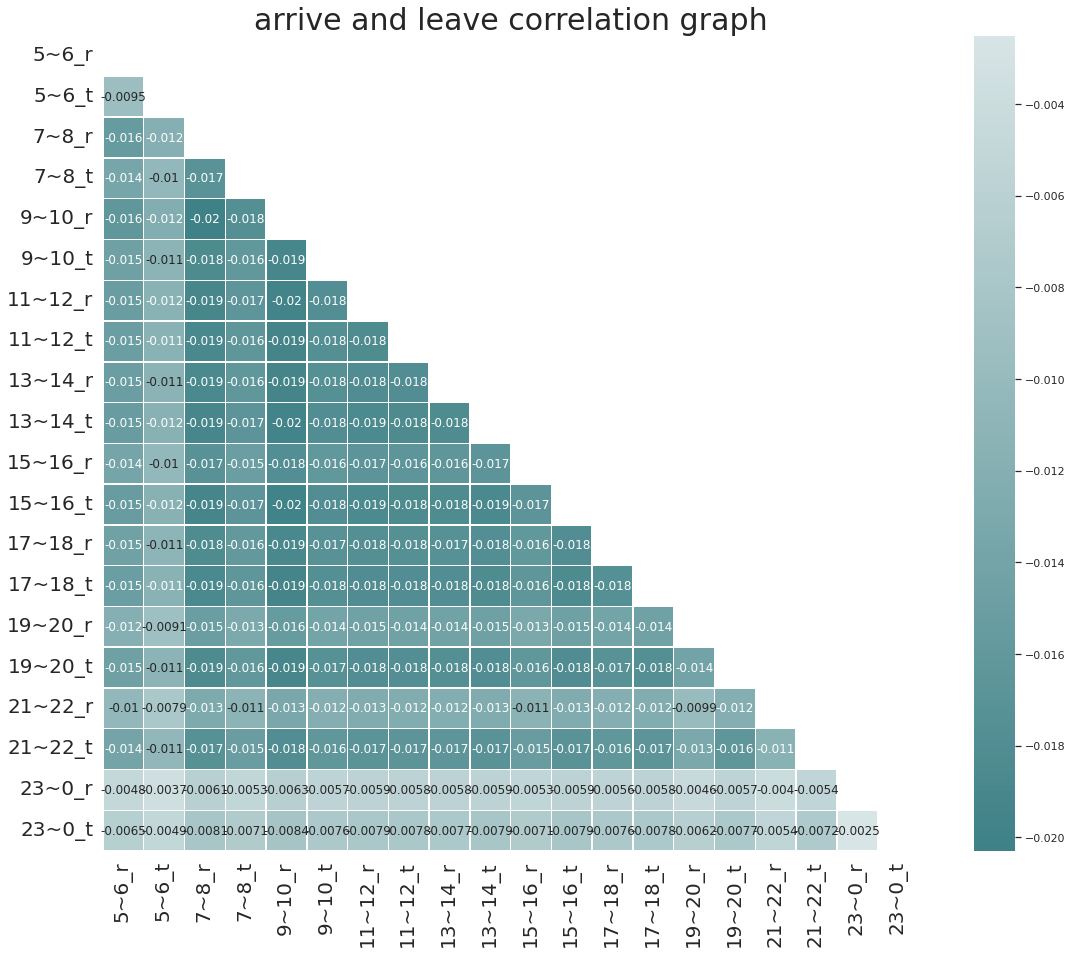

In [ ]:
cor = corr_df[['5~6_r', '5~6_t', '7~8_r', '7~8_t',
       '9~10_r', '9~10_t', '11~12_r', '11~12_t', '13~14_r', '13~14_t',
       '15~16_r', '15~16_t', '17~18_r', '17~18_t', '19~20_r', '19~20_t',
       '21~22_r', '21~22_t', '23~0_r', '23~0_t']].corr()

sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

<br>
탑승/하차 피처간 딱히 상관관계가 보이지 않음.<br>
overfitting을 방지하기 위해 target 데이터만 남겨줌<br>
<br>

In [ ]:
target_time = '17~18_r'
target = corr_df[target_time]

new_df = pd.concat([grp_df, target], axis=1)
new_df = new_df[ new_df[target_time] != 0 ].drop(['거래건수','승하차'], axis=1)
new_df = new_df.reset_index().drop(['index'], axis=1)
new_df

,일자,ARS_ID,시간,17~18_r
0,2022-03-14,1002.0,17,7
1,2022-03-14,1002.0,18,7
2,2022-03-14,1003.0,17,20
3,2022-03-14,1003.0,18,16
4,2022-03-14,1004.0,17,35
...,...,...,...,...
131818,2022-04-30,6618.0,17,5
131819,2022-04-30,6619.0,17,2
131820,2022-04-30,6620.0,17,2
131821,2022-04-30,6622.0,17,16


### 4) 요일 데이터 One-hot Encoding

In [ ]:
new_df['weekday'] = pd.to_datetime(new_df['일자'], format="%Y-%m-%d").dt.weekday
new_df = pd.get_dummies(new_df, columns=['weekday'])
new_df.iloc[:,4:] = new_df.iloc[:,4:].astype('int')
new_df.columns

Index(['일자', 'ARS_ID', '시간', '17~18_r', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

moday is 0, sunday is 6

### 5) 추가 피처 생성

#### - 공휴일 유무 피처

In [ ]:
path = '/content/drive/MyDrive/BusProject/holiday.csv'
month = (3 or 4)

holiday_df = pd.read_csv(path, encoding='cp949')
holiday_df = holiday_df[(holiday_df.년>=2022) & (holiday_df.월==month)]
holiday_df

,순서,년,월,일,설명
75,76,2022,3,1,삼일절
76,77,2022,3,9,대통령선거일


<br>
해당하는 공휴일이 없음<br>
주말 데이터만 추가<br>
<br>

In [ ]:
new_df['weekend'] = new_df.apply(lambda x: 1 if pd.to_datetime(x.일자).weekday()>4 else 0, axis=1)
new_df

,일자,ARS_ID,시간,17~18_r,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekend
0,2022-03-14,1002.0,17,7,1,0,0,0,0,0,0,0
1,2022-03-14,1002.0,18,7,1,0,0,0,0,0,0,0
2,2022-03-14,1003.0,17,20,1,0,0,0,0,0,0,0
3,2022-03-14,1003.0,18,16,1,0,0,0,0,0,0,0
4,2022-03-14,1004.0,17,35,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
131818,2022-04-30,6618.0,17,5,0,0,0,0,0,1,0,1
131819,2022-04-30,6619.0,17,2,0,0,0,0,0,1,0,1
131820,2022-04-30,6620.0,17,2,0,0,0,0,0,1,0,1
131821,2022-04-30,6622.0,17,16,0,0,0,0,0,1,0,1


#### - 기상청 데이터 활용

In [ ]:
path1 = '/content/drive/MyDrive/BusProject/기상청 데이터/3월데이터.csv'
path2 = '/content/drive/MyDrive/BusProject/기상청 데이터/4월데이터.csv'

whether_data1 = pd.read_csv(path1, encoding='cp949')
whether_data2 = pd.read_csv(path2, encoding='cp949')
whether_data = pd.concat([whether_data1,whether_data2]).reset_index().drop(['index'],axis=1)
whether_data = whether_data.iloc[:,2:]
whether_data['일시'] = pd.to_datetime(whether_data['일시'])
whether_data.columns = ['일시', '기온', '강수량', '풍속', '습도']
whether_data['강수량'] = whether_data.강수량.fillna(0)
whether_data

,일시,기온,강수량,풍속,습도
0,2022-03-01 00:00:00,9.1,0.0,0.7,71
1,2022-03-01 01:00:00,8.6,0.0,0.0,67
2,2022-03-01 02:00:00,8.3,0.0,0.0,65
3,2022-03-01 03:00:00,8.8,0.0,1.2,60
4,2022-03-01 04:00:00,6.4,0.0,0.2,97
...,...,...,...,...,...
1459,2022-04-30 19:00:00,13.3,0.0,1.1,76
1460,2022-04-30 20:00:00,12.8,0.0,1.4,82
1461,2022-04-30 21:00:00,12.1,0.0,0.9,88
1462,2022-04-30 22:00:00,11.6,0.0,0.9,89


- 스케일링(Standard - 분류에서 유리)

In [ ]:
# scaler = StandardScaler()
# scaler.fit(whether_data.iloc[:,1:])
# whether_standard = scaler.transform(whether_data.iloc[:,1:])
# whether_standard = pd.DataFrame(data=whether_standard, columns=['기온', '강수량', '풍속', '습도'])

# whether_data_standard = pd.concat([whether_data['일시'],whether_standard], axis=1)
# whether_data_standard

In [ ]:
# new_df_standard = pd.merge(new_df,whether_data_standard, how='left', on='일시')
# new_df_standard = new_df_standard[ ['일시','ARS_ID', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 
#          'weekday_5', 'weekday_6', 'weekend','기온', '강수량', '풍속', '습도', target_time
#          ] ]
# new_df_standard

In [ ]:
# new_df_standard = pd.merge(new_df,whether_data_standard, how='left', on='일시')
# new_df_standard = new_df_standard[ ['일시','ARS_ID', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 
#          'weekday_5', 'weekday_6', 'weekend','기온', '강수량', '풍속', '습도', target_time
#          ] ]
# new_df_standard

- 스케일링(MinMax - 회귀에서 유리)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(whether_data.iloc[:,1:])
whether_minmax = scaler.transform(whether_data.iloc[:,1:])
whether_minmax = pd.DataFrame(data=whether_minmax, columns=['기온', '강수량', '풍속', '습도'])

whether_data_minmax = pd.concat([whether_data['일시'],whether_minmax], axis=1)
whether_data_minmax

,일시,기온,강수량,풍속,습도
0,2022-03-01 00:00:00,0.335616,0.0,0.101449,0.685393
1,2022-03-01 01:00:00,0.318493,0.0,0.000000,0.640449
2,2022-03-01 02:00:00,0.308219,0.0,0.000000,0.617978
3,2022-03-01 03:00:00,0.325342,0.0,0.173913,0.561798
4,2022-03-01 04:00:00,0.243151,0.0,0.028986,0.977528
...,...,...,...,...,...
1459,2022-04-30 19:00:00,0.479452,0.0,0.159420,0.741573
1460,2022-04-30 20:00:00,0.462329,0.0,0.202899,0.808989
1461,2022-04-30 21:00:00,0.438356,0.0,0.130435,0.876404
1462,2022-04-30 22:00:00,0.421233,0.0,0.130435,0.887640


In [ ]:
new_df['시간'] = new_df.apply(lambda x: '0'+str(x.시간) if len(str(x.시간))<2 else str(x.시간), axis=1)
new_df['일시'] = new_df.apply(lambda x: pd.to_datetime(x.일자 + ' ' + x.시간, format='%Y-%m-%d %H') ,axis=1)

In [ ]:
new_df_minmax = pd.merge(new_df,whether_data_minmax, how='left', on='일시')
new_df_minmax = new_df_minmax[ ['일시','ARS_ID', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 
         'weekday_5', 'weekday_6', 'weekend','기온', '강수량', '풍속', '습도', target_time
         ] ]
new_df_minmax

,일시,ARS_ID,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekend,기온,강수량,풍속,습도,17~18_r
0,2022-03-14 17:00:00,1002.0,1,0,0,0,0,0,0,0,0.472603,0.000000,0.275362,1.000000,7
1,2022-03-14 18:00:00,1002.0,1,0,0,0,0,0,0,0,0.376712,0.032847,0.217391,1.000000,7
2,2022-03-14 17:00:00,1003.0,1,0,0,0,0,0,0,0,0.472603,0.000000,0.275362,1.000000,20
3,2022-03-14 18:00:00,1003.0,1,0,0,0,0,0,0,0,0.376712,0.032847,0.217391,1.000000,16
4,2022-03-14 17:00:00,1004.0,1,0,0,0,0,0,0,0,0.472603,0.000000,0.275362,1.000000,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131818,2022-04-30 17:00:00,6618.0,0,0,0,0,0,1,0,1,0.575342,0.000000,0.231884,0.617978,5
131819,2022-04-30 17:00:00,6619.0,0,0,0,0,0,1,0,1,0.575342,0.000000,0.231884,0.617978,2
131820,2022-04-30 17:00:00,6620.0,0,0,0,0,0,1,0,1,0.575342,0.000000,0.231884,0.617978,2
131821,2022-04-30 17:00:00,6622.0,0,0,0,0,0,1,0,1,0.575342,0.000000,0.231884,0.617978,16


# **4. 모델 학습 및 저장**

### 1) 모델 학습

In [ ]:
# target = new_df_standard[target_time]

# input_var = ['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
#              'weekday_5', 'weekday_6', 'weekend', '기온', '강수량', '풍속',
#              '습도']
# final_df = new_df_standard[input_var]
# final_df

In [ ]:
target = new_df_minmax[target_time]

input_var = ['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
             'weekday_5', 'weekday_6', 'weekend', '기온', '강수량', '풍속',
             '습도']
final_df = new_df_minmax[input_var]
final_df

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekend,기온,강수량,풍속,습도
0,1,0,0,0,0,0,0,0,0.472603,0.000000,0.275362,1.000000
1,1,0,0,0,0,0,0,0,0.376712,0.032847,0.217391,1.000000
2,1,0,0,0,0,0,0,0,0.472603,0.000000,0.275362,1.000000
3,1,0,0,0,0,0,0,0,0.376712,0.032847,0.217391,1.000000
4,1,0,0,0,0,0,0,0,0.472603,0.000000,0.275362,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
131818,0,0,0,0,0,1,0,1,0.575342,0.000000,0.231884,0.617978
131819,0,0,0,0,0,1,0,1,0.575342,0.000000,0.231884,0.617978
131820,0,0,0,0,0,1,0,1,0.575342,0.000000,0.231884,0.617978
131821,0,0,0,0,0,1,0,1,0.575342,0.000000,0.231884,0.617978


In [ ]:
target

0          7
1          7
2         20
3         16
4         35
          ..
131818     5
131819     2
131820     2
131821    16
131822     6
Name: 17~18_r, Length: 131823, dtype: int64

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(final_df, target, test_size=0.2, shuffle=True, random_state=34)

In [ ]:
rf = RandomForestRegressor(random_state=1217)
rf.fit(x_train, y_train)

RandomForestRegressor(random_state=1217)

In [ ]:
y_pred = rf.predict(x_test)

MAE =  mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
MSLE = mean_squared_log_error(y_test, y_pred)
RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print(MAE, MSE, RMSE, MSLE, RMSLE, R2, sep='\n')

12.948586165275062
453.1429981147474
21.28715570748585
1.5058675831262178
1.2271379641777114
0.012339484419058966


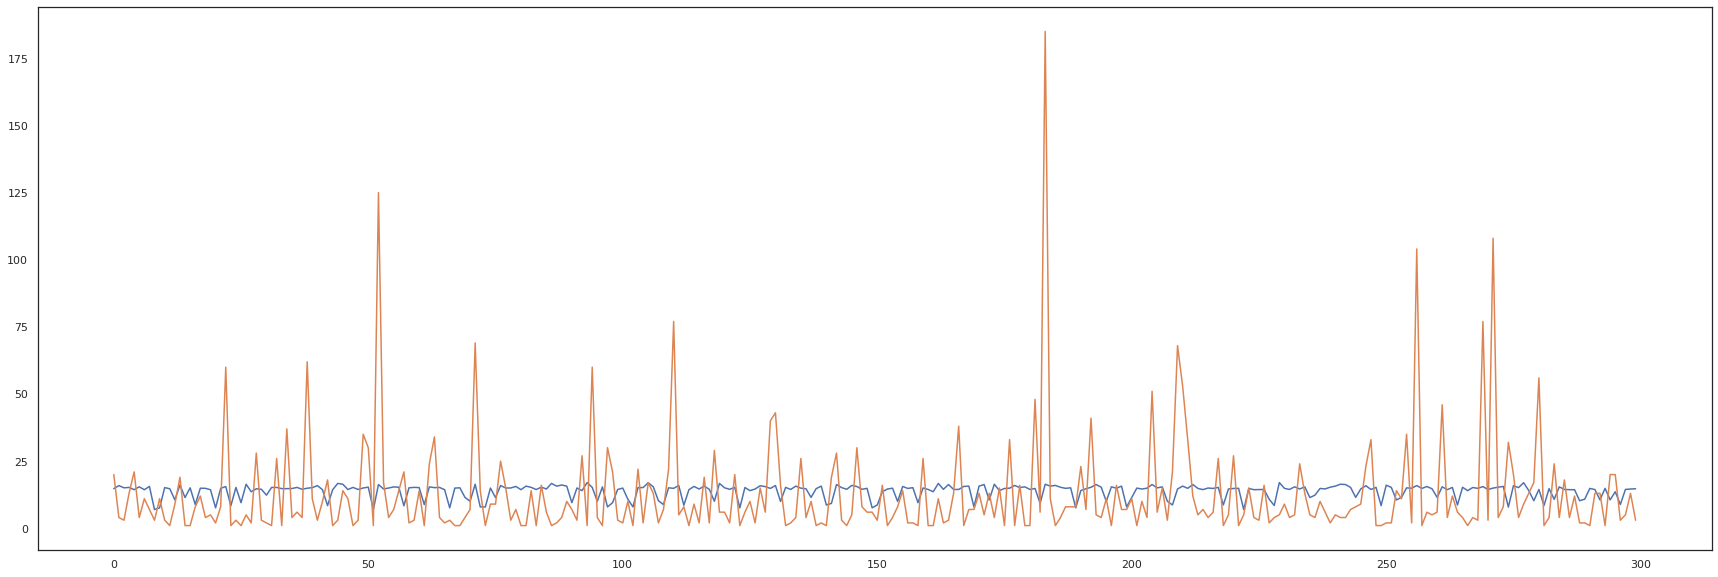

In [ ]:
train_pred = rf.predict(x_train)

fig = plt.figure(figsize=(30,10))
fig.add_subplot()
plt.plot(train_pred[:300].tolist())
plt.plot(y_train[:300].tolist())

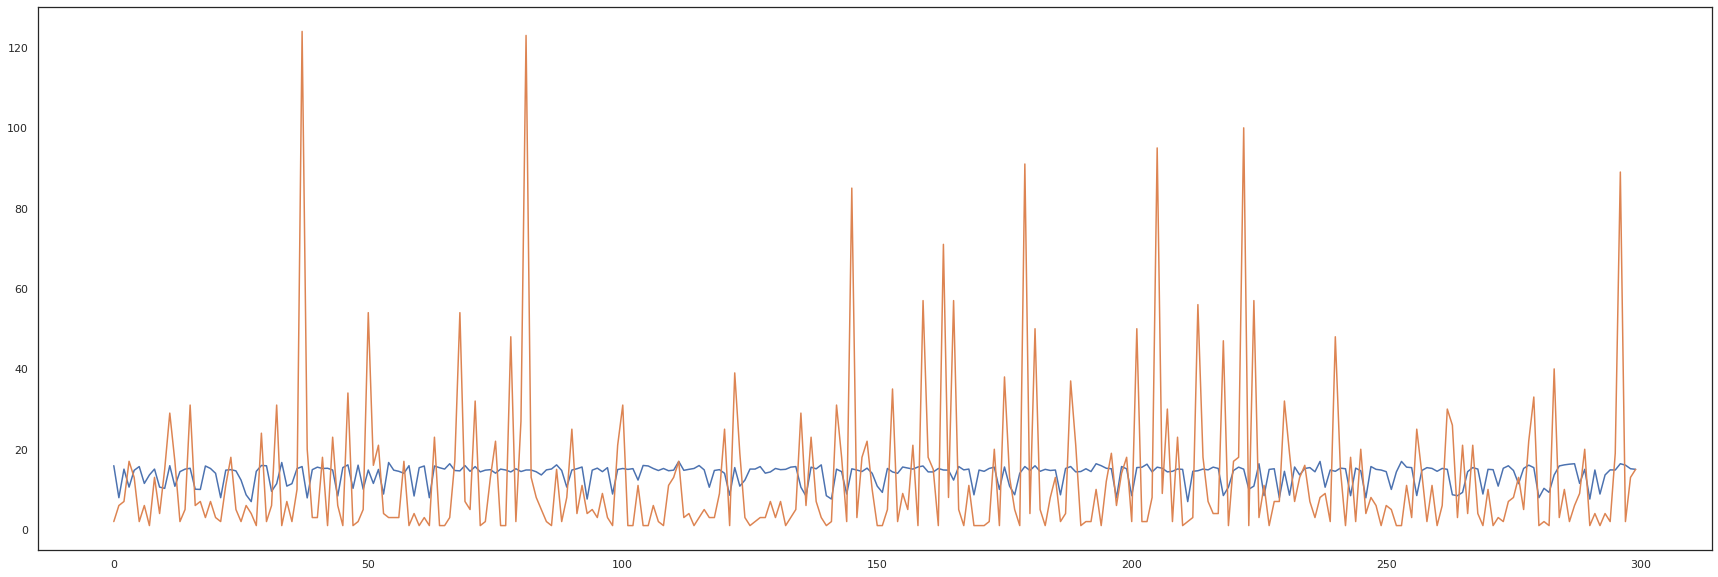

In [ ]:
fig = plt.figure(figsize=(30,10))
fig.add_subplot()
plt.plot(y_pred[:300].tolist())
plt.plot(y_test[:300].tolist())

### 2) 모델 저장

In [ ]:
joblib.dump(rf, '/content/drive/MyDrive/BusProject/Model/bus_model_3.pkl')

['/content/drive/MyDrive/BusProject/Model/bus_model_3.pkl']

#### - 1차 모델

In [ ]:
path = "/content/drive/MyDrive/BusProject/Model/bus_model_prototype.pkl"
loaded_model = joblib.load(path)
loaded_model

RandomForestRegressor(criterion='mse', random_state=1217)

In [ ]:
test_feature = x_test.iloc[:,:-6]
test_feature.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
794737,0,0,0,0,1,0,0
793414,0,0,0,0,1,0,0
992280,0,0,1,0,0,0,0
1209317,1,0,0,0,0,0,0
457202,0,0,0,0,1,0,0


In [ ]:
y_pred = loaded_model.predict(test_feature)

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot()
plt.plot(y_pred[:100])
plt.plot(y_test.reset_index()[target_time][:100])

  #### - 2차 모델

In [ ]:
path2 = "/content/drive/MyDrive/BusProject/Model/bus_model_2.pkl"
loaded_model2 = joblib.load(path2)
loaded_model2

RandomForestRegressor(random_state=1217)

In [ ]:
test_feature2 = x_test.iloc[:,:-2]
test_feature2.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,기온,강수량,풍속,습도
794737,0,0,0,0,1,0,0,9,0,0,88
793414,0,0,0,0,1,0,0,9,0,2,99
992280,0,0,1,0,0,0,0,11,0,1,40
1209317,1,0,0,0,0,0,0,4,0,0,45
457202,0,0,0,0,1,0,0,10,0,0,69


In [ ]:
y_pred2 = loaded_model2.predict(test_feature2)

In [ ]:
fig = plt.figure(figsize=(30,20))
fig.add_subplot()
plt.plot(y_pred2[-500:].tolist())
plt.plot(y_test[-500:].tolist())

#### -3차 모델

In [ ]:
path3 = "/content/drive/MyDrive/BusProject/Model/bus_model_3.pkl"
loaded_model3 = joblib.load(path3)
loaded_model3

RandomForestRegressor(random_state=1217)

In [ ]:
test_feature3 = x_test
test_feature3.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,기온,강수량,풍속,습도,hollyday,weekend
794737,0,0,0,0,1,0,0,9,0,0,88,0,0
793414,0,0,0,0,1,0,0,9,0,2,99,0,0
992280,0,0,1,0,0,0,0,11,0,1,40,0,0
1209317,1,0,0,0,0,0,0,4,0,0,45,0,0
457202,0,0,0,0,1,0,0,10,0,0,69,0,0


In [ ]:
y_pred3 = loaded_model3.predict(test_feature3)

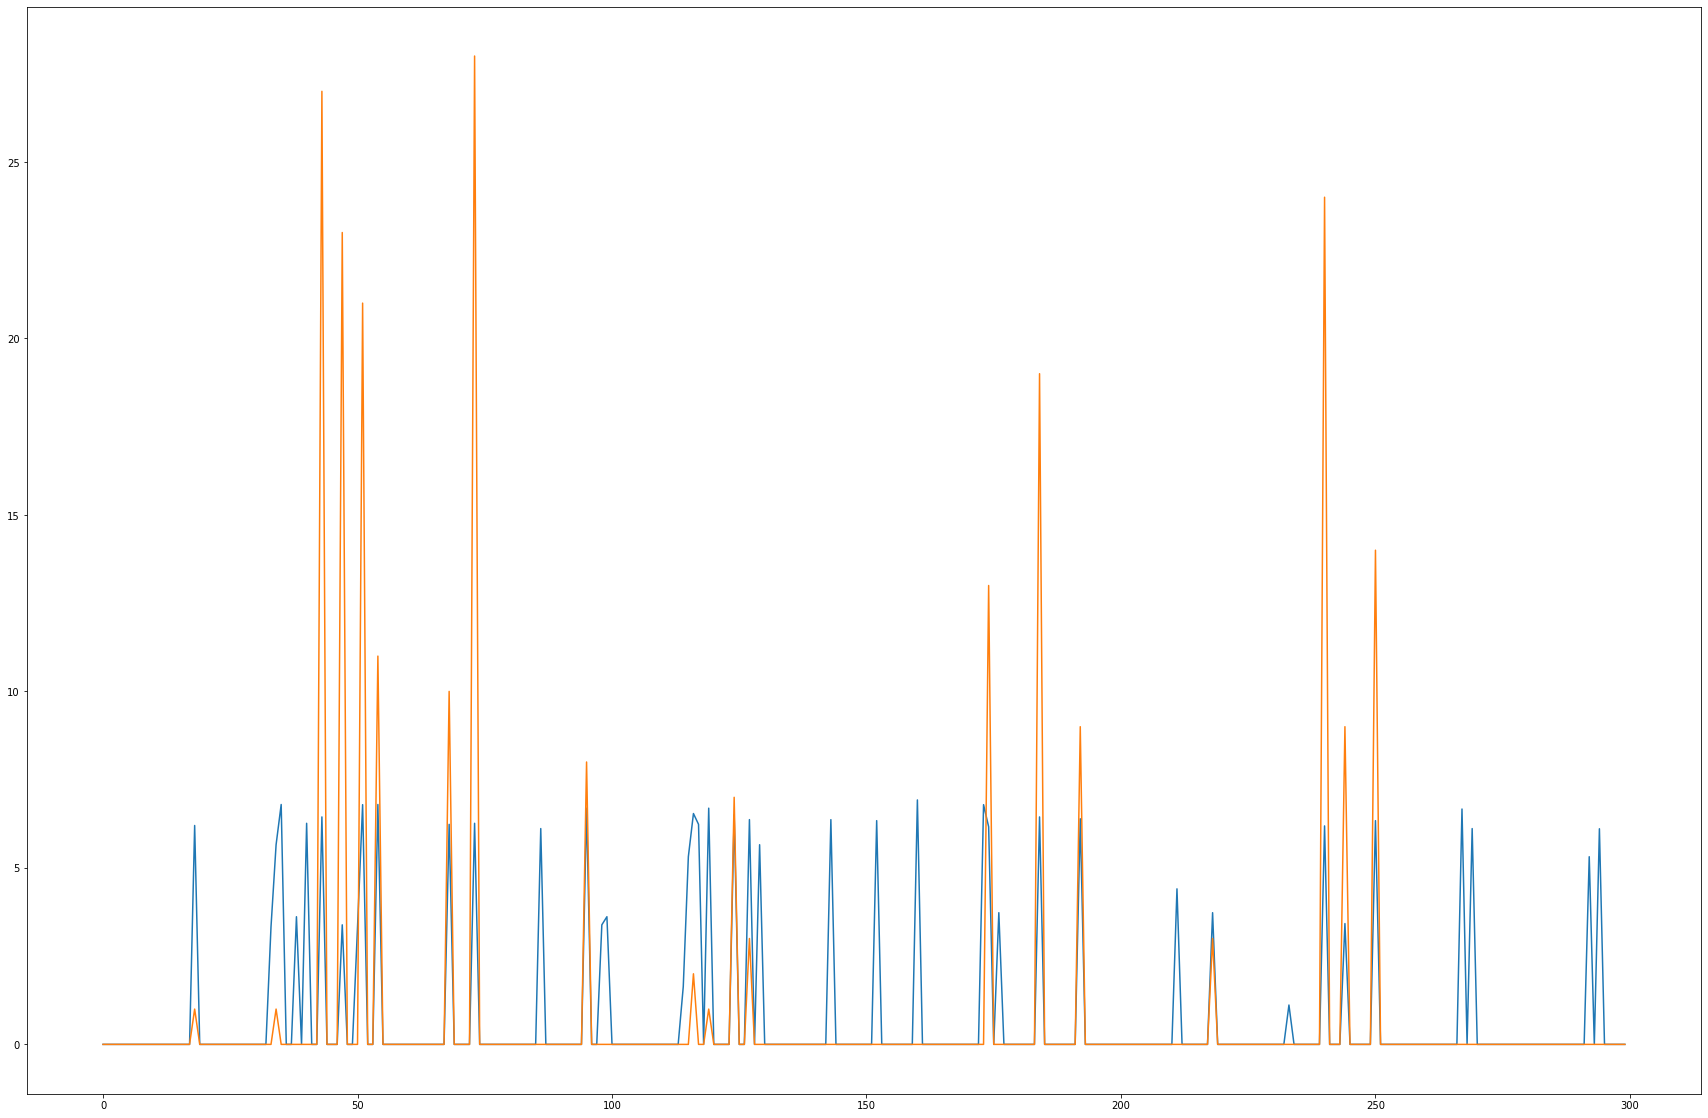

In [ ]:
fig = plt.figure(figsize=(30,20))
fig.add_subplot()
plt.plot(y_pred3[:300].tolist())
plt.plot(y_test[:300].tolist())